<a href="https://colab.research.google.com/github/Nandusasikumar1/Fashion_mnist/blob/main/fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
import torch
from torch import nn

import torchvision
from torchvision import datasets,transforms
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

## Loading Fashionmnist Dataset

In [20]:
from torchvision import datasets

train_data = datasets.FashionMNIST(root='data',# where to download data to
                                   train  = True,
                                   download =True,
                                   transform=ToTensor(),
                                   target_transform=None)

test_data = datasets.FashionMNIST(root='data',# where to download data to
                                   train  = False,
                                   download =True,
                                   transform=ToTensor(),
                                   target_transform=None)

#Creating data loader for training and test data

In [21]:
from  torch.utils.data import DataLoader

Batch_size = 32

train_data_loader = DataLoader(dataset = train_data,
                               batch_size = Batch_size,
                               shuffle=True)

test_data_loader = DataLoader(dataset = test_data,
                              batch_size=Batch_size,
                              shuffle=False)

train_data_loader,test_data_loader

(<torch.utils.data.dataloader.DataLoader at 0x7fea40ab8bb0>,
 <torch.utils.data.dataloader.DataLoader at 0x7fea40ab84f0>)

## create device variable to switch between hardware accelerators(cpu or gpu)

In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

##Creating a function for training the data

In [23]:
def train_step(data_loader,model,optimizer,loss_fn,accuracy_fn,device=device):

  train_loss,train_acc = 0,0
  model.train()

  for batch,(image,label) in enumerate(data_loader):
    # print(image.shape)

    image = image.to(device)
    label = label.to(device)
    # print(label.dtype)
   

    y_pred = model(image)

    loss = loss_fn(y_pred,label)

    train_loss += loss 
    train_acc += accuracy_fn(y_true=label,y_pred=y_pred.argmax(dim=1))

    optimizer.zero_grad()

    loss.backward()

    optimizer.step()

   

    
    # divide total train loss by length of train data loader
  train_loss/=len(data_loader)
  train_acc/=len(data_loader)

  print(f'Train loss : {train_loss} | train_acc : {train_acc}')

## Creating a function for testing the data

In [6]:
def test_step(data_loader,model,loss_fn,accuracy_fn,device=device):
  test_loss,test_acc = 0,0

  model.eval()
  with torch.inference_mode():

    for image_test,label_test in data_loader:

      image_test,label_test = image_test.to(device),label_test.to(device)

      test_pred = model(image_test)

      test_loss+=loss_fn(test_pred,label_test)
      test_acc+= accuracy_fn(y_true=label_test,y_pred=test_pred.argmax(dim=1))

    test_loss/=len(data_loader)

    test_acc/=len(data_loader)

  print(f'Test loss : {test_loss} | test_acc : {test_acc}')

## Function for measuring the accuracy of predictions

In [24]:
def accuracy(y_true,y_pred):
  correct = torch.eq(y_true,y_pred).sum()
  acc = (correct/len(y_pred))*100
  return acc

#Building CNN.

## Here I used a 2 convolutional block architecure where each block contains two convolutional layers and one maxpooling layer.Used Relu as activation function

In [25]:

class FashionMNISTV2(nn.Module):
  def __init__(self,input_shape,hidden_units,output_shape):
    super().__init__() # values we can set ourseleves in neural network a re called hyperparameters               
    self.conv_block_1 = nn.Sequential(
        
        nn.Conv2d(
            in_channels = input_shape,
            out_channels= hidden_units,
            kernel_size = 3,
            stride = 1,
            padding = 1
        ),

        nn.ReLU(),

        nn.Conv2d(
            in_channels=hidden_units,
            out_channels = hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
          ),

        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )



#block2


    self.conv_block_2 = nn.Sequential(
        nn.Conv2d(
           in_channels = hidden_units,
           out_channels = hidden_units,
           kernel_size=3,
           stride=1,
           padding=1
        ),

        nn.ReLU(),

        nn.Conv2d(
            in_channels = hidden_units,
            out_channels = hidden_units,
            kernel_size=3,
            stride=1,
            padding=1
        ),

        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)

    )

# classifier layer

    self.classifier = nn.Sequential(
        nn.Flatten(),
        nn.Linear(in_features=hidden_units*7*7, #there is a trick to calculate this
        out_features=output_shape)
     
        
    )

  def forward(self,x):
    x=self.conv_block_1(x)
    # print(f'output shape of convblock1: {x.shape}')
    x=self.conv_block_2(x)
    # print(f'output shape of convblock2: {x.shape}')
    x=self.classifier(x)
    # print(f'output shape of classifier: {x.shape}')
    return x

torch.manual_seed(42)
model = FashionMNISTV2(input_shape=1,
                         hidden_units=10,
                         output_shape=10).to(device)

## Create loss function to calculate the loss and optimizer for optimizing the weights and biases in the neural network.

In [26]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(),
                            lr=0.1)


## Training

In [27]:
from tqdm.auto import tqdm

epochs = 8
for epoch in tqdm(range(epochs)):
  print(f'Epoch : {epoch}\n')

  train_step(model=model,
             loss_fn=loss_fn,
             optimizer=optimizer,
             accuracy_fn=accuracy,
             data_loader=train_data_loader)
  
  test_step(model=model,
            
            data_loader=test_data_loader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy,
            device=device)

  0%|          | 0/8 [00:00<?, ?it/s]

Epoch : 0

Train loss : 0.5786511898040771 | train_acc : 79.11666870117188
Test loss : 0.39426273107528687 | test_acc : 85.4632568359375
Epoch : 1

Train loss : 0.3563888669013977 | train_acc : 87.18333435058594
Test loss : 0.35927340388298035 | test_acc : 86.7511978149414
Epoch : 2

Train loss : 0.3189637362957001 | train_acc : 88.5
Test loss : 0.3225628733634949 | test_acc : 87.98921203613281
Epoch : 3

Train loss : 0.2969309985637665 | train_acc : 89.25167083740234
Test loss : 0.31213369965553284 | test_acc : 88.60822296142578
Epoch : 4

Train loss : 0.2847355604171753 | train_acc : 89.6050033569336
Test loss : 0.3048416078090668 | test_acc : 89.02755737304688
Epoch : 5

Train loss : 0.27608129382133484 | train_acc : 89.88999938964844
Test loss : 0.2944765090942383 | test_acc : 89.5367431640625
Epoch : 6

Train loss : 0.2664162516593933 | train_acc : 90.35833740234375
Test loss : 0.30725255608558655 | test_acc : 88.7380142211914
Epoch : 7

Train loss : 0.25841301679611206 | train_ac

## Making predictions

In [28]:
test_features_batch,test_labels_batch = next(iter(test_data_loader))

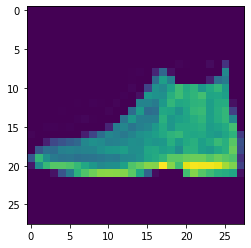

In [29]:
import matplotlib.pyplot as plt
plt.imshow(test_features_batch[0][0])

In [30]:
class_map = dict(zip(test_data.class_to_idx.values(),test_data.class_to_idx.keys()))

In [31]:
class_map

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [32]:

model.eval()
with torch.inference_mode():
  pred=model(test_features_batch[0].unsqueeze(0).to(device))
  print(class_map[pred.argmax(dim=1).item()])

Ankle boot


In [33]:
print(pred.argmax(dim=1))

tensor([9], device='cuda:0')
